# Klassifikationsmodelle für Predictive Maintenance
Dieses Notebook enthält die Modellierung und Evaluierung von Klassifikationsmodellen zur Vorhersage von Maschinenausfällen auf Basis des AI4I 2020-Datensatzes.

## Modelle:
- Random Forest
- XGBoost
- Logistische Regression

Die Zielvariable ist `machine_failure` (binär: 0 = kein Fehler, 1 = Fehler).


## 1. Daten laden

Wir laden die vorbereiteten Datensätze aus dem Feature-Engineering-Notebook. Diese wurden als Pickle-Dateien gespeichert, um die Modellierung modular zu halten.


In [13]:
def clean_column_names(df, return_mapping=False):
    """
    Entfernt unerlaubte Zeichen ([, ], <, >) aus den Spaltennamen,
    z. B. für die Verwendung in XGBoost.
    """
    original_names = df.columns
    cleaned_names = original_names.str.replace(r"[\[\]<>]", "_", regex=True)

    df_cleaned = df.copy()
    df_cleaned.columns = cleaned_names

    if return_mapping:
        mapping = dict(zip(original_names, cleaned_names))
        return df_cleaned, mapping
    return df_cleaned


In [ ]:
import pandas as pd

# Unskalierte Daten für RF & XGB
X_train_raw = pd.read_pickle("../data/X_train.pkl")
X_test_raw = pd.read_pickle("../data/X_test.pkl")

# XGBoost-kompatibel machen
X_train, name_map = clean_column_names(X_train_raw, return_mapping=True)
X_test = clean_column_names(X_test_raw)

# Reduzierte Daten für Logistische Regression
X_train_reduced = pd.read_pickle("../data/X_train_reduced.pkl")
X_test_reduced = pd.read_pickle("../data/X_test_reduced.pkl")

#  Zielvariable
y_train = pd.read_pickle("../data/y_train.pkl")
y_test = pd.read_pickle("../data/y_test.pkl")

# Feature-Namen aktualisieren
feature_names = X_train.columns

## 2. Modelltraining

Wir trainieren drei Klassifikatoren:
- Random Forest (als robuste Baseline)
- XGBoost (für leistungsstarke Imbalanced-Klassifikation)
- Logistische Regression (interpretiertes lineares Modell)

Die Modelle werden auf dem gleichen stratifizierten Datensatz trainiert. Die logistische Regression nutzt `X_reduced`, um Multikollinearität zu vermeiden.


In [15]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Verhältnis für XGBoost bei Imbalance
xgb_weight = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=xgb_weight, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Logistische Regression": LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000)
}

trained_models = {}
predictions = {}
probabilities = {}


## 3. Evaluation

Zur Beurteilung der Modellleistung werden folgende Metriken verwendet:
- **F1-Score**, **Precision**, **Recall** (besonders relevant bei Imbalance)
- **ROC AUC**
- **Confusion Matrix**


In [16]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

for name, model in models.items():
    print(f"🔍 {name}")

    if name == "Logistische Regression":
        model.fit(X_train_reduced, y_train)
        y_pred = model.predict(X_test_reduced)
        y_proba = model.predict_proba(X_test_reduced)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    trained_models[name] = model
    predictions[name] = y_pred
    probabilities[name] = y_proba

    print(classification_report(y_test, y_pred, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)


🔍 Random Forest
              precision    recall  f1-score   support

           0      0.998     0.999     0.999      1932
           1      0.970     0.956     0.963        68

    accuracy                          0.998      2000
   macro avg      0.984     0.977     0.981      2000
weighted avg      0.997     0.998     0.997      2000

ROC AUC: 0.9838478869808794
Confusion Matrix:
 [[1930    2]
 [   3   65]]
------------------------------------------------------------
🔍 XGBoost
              precision    recall  f1-score   support

           0      0.999     0.998     0.999      1932
           1      0.957     0.971     0.964        68

    accuracy                          0.998      2000
   macro avg      0.978     0.985     0.981      2000
weighted avg      0.998     0.998     0.998      2000

ROC AUC: 0.993754567044209
Confusion Matrix:
 [[1929    3]
 [   2   66]]
------------------------------------------------------------
🔍 Logistische Regression
              precision   

c:\Users\PSibma\pdm365-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:33:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 4. Visuelle Evaluation: ROC- & Precision-Recall-Kurven

Die folgenden Diagramme zeigen die Performance der Klassifikationsmodelle im Vergleich.
Insbesondere bei unausgewogenen Klassenverteilungen ist die Precision-Recall-Kurve oft aussagekräftiger als die ROC-Kurve.


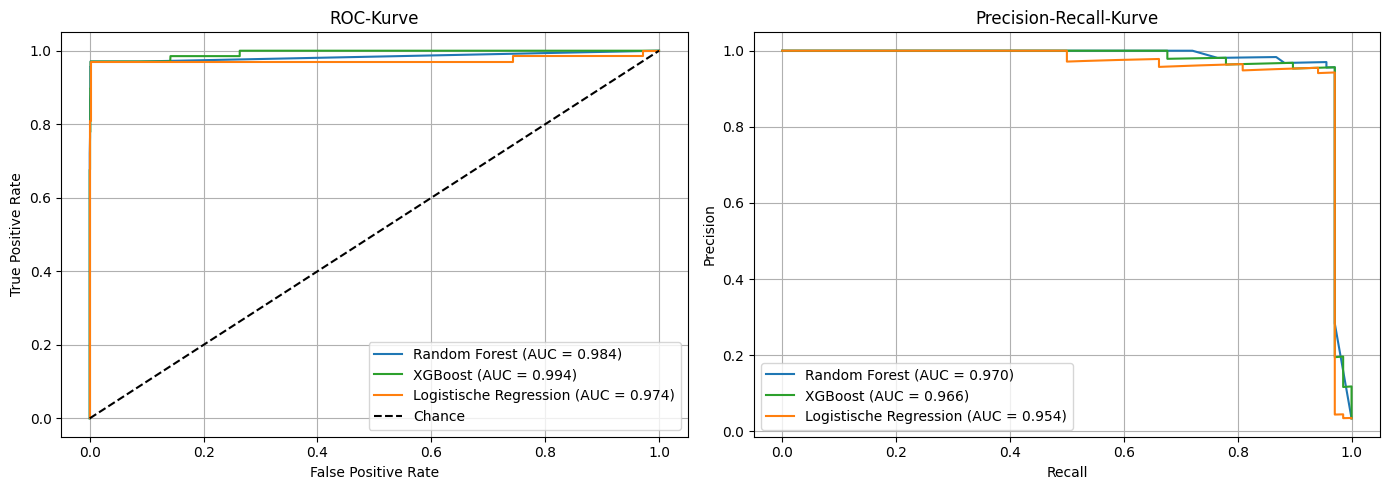

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Farben für Konsistenz
colors = {
    "Random Forest": "tab:blue",
    "XGBoost": "tab:green",
    "Logistische Regression": "tab:orange"
}

plt.figure(figsize=(14, 5))

# ROC-Kurven
plt.subplot(1, 2, 1)
for name, y_proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})", color=colors.get(name))

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve")
plt.legend()
plt.grid(True)

# Precision-Recall-Kurven
plt.subplot(1, 2, 2)
for name, y_proba in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})", color=colors.get(name))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Feature Importance (Random Forest & XGBoost)

Die folgenden Diagramme zeigen, welche Merkmale am stärksten zur Vorhersage eines Maschinenfehlers beitragen. Die Feature Importances basieren auf dem Informationsgewinn während der Modellbildung.


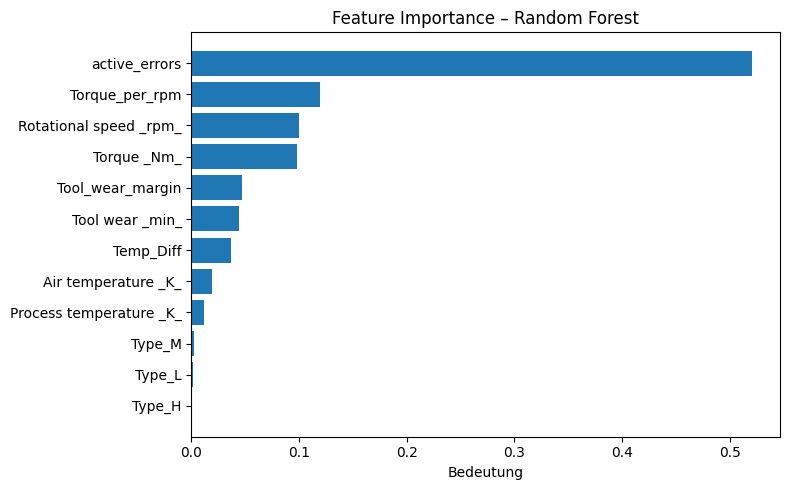

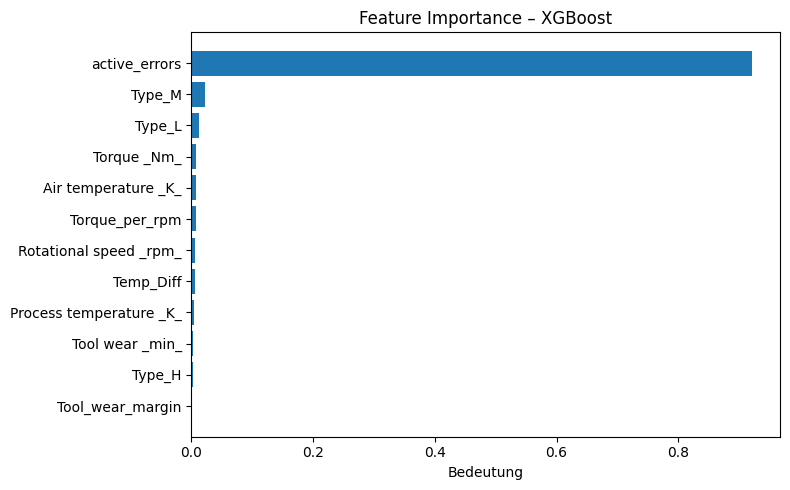

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(importances)), importances[indices[::-1]], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices[::-1]])
    plt.xlabel("Bedeutung")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot für beide Modelle
plot_feature_importance(trained_models["Random Forest"], feature_names, "Feature Importance – Random Forest")
plot_feature_importance(trained_models["XGBoost"], feature_names, "Feature Importance – XGBoost")


## 6. Alternativer Modellvergleich ohne `active_errors`

Da das Merkmal `active_errors` direkt mit dem Maschinenausfall korreliert, testen wir die Modellleistung ohne dieses Feature. Ziel ist es zu prüfen, ob auch rein sensorbasierte Merkmale eine zuverlässige Vorhersage ermöglichen.


In [19]:
# Neue Feature-Matrizen ohne active_errors
X_train_noae = X_train.drop(columns="active_errors")
X_test_noae = X_test.drop(columns="active_errors")

# Feature-Namen aktualisieren
feature_names_noae = X_train_noae.columns

# Modelle erneut definieren (identisch)
models_noae = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=xgb_weight, eval_metric="logloss", random_state=42),
    "Logistische Regression": LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000)
}

trained_models_noae = {}
probabilities_noae = {}

# Training & Evaluation
for name, model in models_noae.items():
    print(f"🔍 {name} (ohne active_errors)")

    if name == "Logistische Regression":
        model.fit(X_train_reduced, y_train)  # unverändert, da X_reduced active_errors nicht enthält
        y_pred = model.predict(X_test_reduced)
        y_proba = model.predict_proba(X_test_reduced)[:, 1]
    else:
        model.fit(X_train_noae, y_train)
        y_pred = model.predict(X_test_noae)
        y_proba = model.predict_proba(X_test_noae)[:, 1]

    trained_models_noae[name] = model
    probabilities_noae[name] = y_proba

    print(classification_report(y_test, y_pred, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)


🔍 Random Forest (ohne active_errors)
              precision    recall  f1-score   support

           0      0.988     0.998     0.993      1932
           1      0.918     0.662     0.769        68

    accuracy                          0.987      2000
   macro avg      0.953     0.830     0.881      2000
weighted avg      0.986     0.987     0.985      2000

ROC AUC: 0.9590069723541591
Confusion Matrix:
 [[1928    4]
 [  23   45]]
------------------------------------------------------------
🔍 XGBoost (ohne active_errors)
              precision    recall  f1-score   support

           0      0.992     0.990     0.991      1932
           1      0.736     0.779     0.757        68

    accuracy                          0.983      2000
   macro avg      0.864     0.885     0.874      2000
weighted avg      0.984     0.983     0.983      2000

ROC AUC: 0.9746148459383753
Confusion Matrix:
 [[1913   19]
 [  15   53]]
------------------------------------------------------------
🔍 Logist

## 7. Visuelle Evaluation ohne `active_errors`

Die folgenden Diagramme zeigen die ROC- und Precision-Recall-Kurven für die Modelle, die ohne das stark prädiktive Feature `active_errors` trainiert wurden.
Ziel ist es zu bewerten, wie stark sich die Modellgüte verändert, wenn nur sensorbasierte Daten berücksichtigt werden.


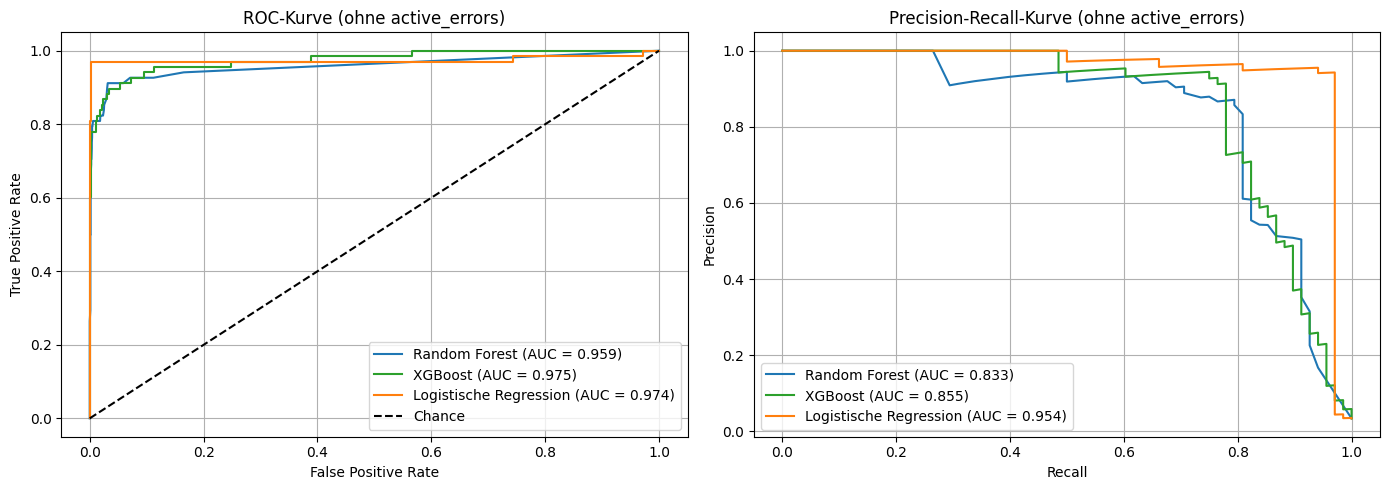

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Farben beibehalten
colors = {
    "Random Forest": "tab:blue",
    "XGBoost": "tab:green",
    "Logistische Regression": "tab:orange"
}

plt.figure(figsize=(14, 5))

# ROC-Kurve
plt.subplot(1, 2, 1)
for name, y_proba in probabilities_noae.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})", color=colors.get(name))

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve (ohne active_errors)")
plt.legend()
plt.grid(True)

# Precision-Recall-Kurve
plt.subplot(1, 2, 2)
for name, y_proba in probabilities_noae.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})", color=colors.get(name))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurve (ohne active_errors)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 8. Feature Importance ohne `active_errors`

Nach dem Entfernen des dominanten Merkmals `active_errors` ergibt sich ein realistischeres Bild der verbleibenden Einflussgrößen. Die folgenden Diagramme zeigen die wichtigsten Merkmale aus Sicht des Random Forest und XGBoost.


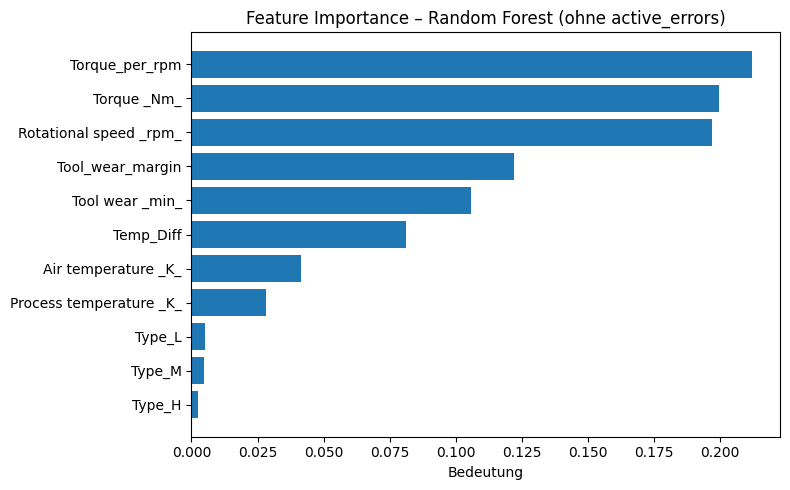

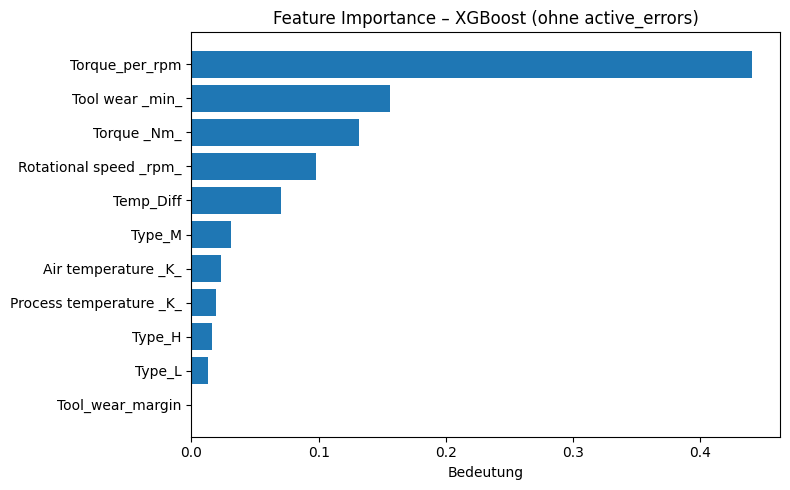

In [21]:
# Gleiche Plot-Funktion wie vorher – erneut nutzen:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(importances)), importances[indices[::-1]], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices[::-1]])
    plt.xlabel("Bedeutung")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Feature Importance ohne active_errors
plot_feature_importance(trained_models_noae["Random Forest"], feature_names_noae, "Feature Importance – Random Forest (ohne active_errors)")
plot_feature_importance(trained_models_noae["XGBoost"], feature_names_noae, "Feature Importance – XGBoost (ohne active_errors)")


## 9. Zusammenfassung & Schlussfolgerungen

### Ziel & Datengrundlage

Ziel dieses Notebooks war die prototypische Umsetzung und Evaluierung verschiedener Klassifikationsmodelle zur Vorhersage von Maschinenausfällen auf Basis des AI4I 2020-Datensatzes. Die Zielvariable `Machine failure` ist binär (0 = kein Fehler, 1 = Fehler) und stark unausgewogen (~3.4 % Fehler).

### Verglichene Modelle & Metriken

Trainierte Modelle:
- Random Forest
- XGBoost
- Logistische Regression

Evaluationsmetriken:
- Precision, Recall, F1-Score
- ROC-AUC
- Precision-Recall-Kurven
- Confusion Matrix

Alle Modelle wurden mit stratifiziertem Split (80/20), geeigneter Behandlung der Imbalance (`class_weight` / `scale_pos_weight`) und standardisierter Evaluation verglichen.

---

### Ergebnisse mit `active_errors` (vollständiges Feature-Set)

| Modell                 | ROC-AUC | Precision (1) | Recall (1) | F1-Score (1) |
|------------------------|---------|---------------|------------|---------------|
| Random Forest          | 0.984   | 0.970         | 0.956      | 0.963         |
| XGBoost                | 0.994   | 0.957         | 0.971      | 0.964         |
| Logistische Regression | 0.974   | 0.943         | 0.971      | 0.957         |

Alle Modelle zeigten eine sehr hohe Vorhersagequalität. Die ROC- und PR-Kurven zeigten nahezu perfekte Trennung, was auf die starke Prädiktivität des Merkmals `active_errors` zurückzuführen ist.

---

### Ergebnisse ohne `active_errors` (realistischer Anwendungsfall)

| Modell                 | ROC-AUC | Precision (1) | Recall (1) | F1-Score (1) |
|------------------------|---------|---------------|------------|---------------|
| Random Forest          | 0.959   | 0.918         | 0.662      | 0.769         |
| XGBoost                | 0.975   | 0.736         | 0.779      | 0.757         |
| Logistische Regression | 0.974   | 0.943         | 0.971      | 0.957         |

Ohne das Feature `active_errors` zeigten Random Forest und XGBoost spürbare Einbußen, insbesondere beim Recall. Die logistische Regression blieb hingegen stabil, da sie `active_errors` nie verwendet hatte.

---

### Interpretation & Modellwahl

- **XGBoost** zeigte insgesamt die robusteste Leistung – sowohl mit als auch ohne `active_errors`.
- Die **logistische Regression** erwies sich als stabiler, interpretierbarer und robust gegenüber Feature-Reduktion.
- **Random Forest** schnitt gut ab, war aber am stärksten vom Feature `active_errors` abhängig.
- Die Feature Importance zeigte, dass `Torque`, `Tool wear`, `Type_L` und `Rotational speed` auch ohne Fehlerindikatoren relevante prädiktive Merkmale sind.

---

## 10. Speicherung der Modelle

Die trainierten Klassifikationsmodelle werden als `.pkl`-Dateien im Unterordner `models/classification/` gespeichert. Der `StandardScaler` wird separat im Ordner `models/scaler/` abgelegt. Damit sind alle Artefakte bereit für den späteren Einsatz im Inferenzskript (`predict.py`) und die Integration in Microsoft Dynamics 365 CE.

### Übersicht der gespeicherten Dateien

| Pfad & Dateiname                                          | Inhalt / Zweck                                      |
|-----------------------------------------------------------|-----------------------------------------------------|
| `models/classification/random_forest_with_ae.pkl`         | Random-Forest-Modell mit allen Features             |
| `models/classification/xgboost_with_ae.pkl`               | XGBoost-Modell mit allen Features                   |
| `models/classification/logistische_regression_with_ae.pkl`| LogReg-Modell mit allen Features (wie `no_ae`)      |
| `models/classification/random_forest_no_ae.pkl`           | Random-Forest-Modell **ohne** `active_errors`       |
| `models/classification/xgboost_no_ae.pkl`                 | XGBoost-Modell **ohne** `active_errors`             |
| `models/classification/logistische_regression_no_ae.pkl`  | LogReg-Modell ohne `active_errors` (identisch)      |
| `models/scaler/standard_scaler.pkl`                       | `StandardScaler` zur Standardisierung bei Inferenz  |

> ℹ️ Der Scaler wird insbesondere für die Inferenz mit skalierungsabhängigen Modellen wie Autoencoder (und ggf. LogReg) benötigt.


In [23]:
import os
import joblib

# Zielverzeichnisse erstellen
os.makedirs("../models/classification", exist_ok=True)
os.makedirs("../models/scaler", exist_ok=True)

# Modelle mit active_errors
for name, model in trained_models.items():
    filename = f"../models/classification/{name.replace(' ', '_').lower()}_with_ae.pkl"
    joblib.dump(model, filename)

# Modelle ohne active_errors
for name, model in trained_models_noae.items():
    filename = f"../models/classification/{name.replace(' ', '_').lower()}_no_ae.pkl"
    joblib.dump(model, filename)

# Scaler laden und separat speichern
scaler = joblib.load("../data/standard_scaler.pkl")
joblib.dump(scaler, "../models/scaler/standard_scaler.pkl")

print("✅ Klassifikationsmodelle und Scaler wurden erfolgreich gespeichert.")


✅ Klassifikationsmodelle und Scaler wurden erfolgreich gespeichert.


### Erstellung eines Beispiel-Eingabedatensatzes (`sample_input`)

Für die spätere Verwendung im `predict.py`-Skript wird aus dem bestehenden `X_test` ein kleiner, exemplarischer Eingabedatensatz erstellt. Dieser dient als Testbasis für die Klassifikations- und Anomalievorhersage.

- **Quelle:** `X_test.pkl` mit allen Features (inkl. `active_errors`)
- **Größe:** 5 zufällige Zeilen
- **Speicherformate:** `.pkl`, `.csv`, `.json`

Der folgende Code speichert den Beispielinput im Ordner `data/`:

In [7]:
import pandas as pd

# Pfad zum X_test mit allen Features (inkl. active_errors)
X_test = pd.read_pickle('../data/X_test.pkl')

# 5 zufällige Zeilen extrahieren
sample_input = X_test.sample(5, random_state=42)

# Datei speichern als .pkl
sample_input.to_pickle('../data/sample_input.pkl')
# Optional auch als CSV & JSON
sample_input.to_csv('../data/sample_input.csv', index=False)
sample_input.to_json('../data/sample_input.json', orient='records', indent=2)

print("✅ Sample input gespeichert.")


✅ Sample input gespeichert.
